In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import( RandomForestClassifier, AdaBoostClassifier, 
                             GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.cross_validation import KFold

## Feature Exploration, Engineering and Cleaning

In [2]:
# Load in the train and test Dataset
train = pd.read_csv('./dataset/train.csv')
test= pd.read_csv('./dataset/test.csv')

# store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Feature Engineering

In [3]:

full_data= [train, test]

# Name_length: length of the name
train['Name_length']= train['Name'].apply(len)
test['Name_length']= test['Name'].apply(len)

# Feature that tells wether a passenger had a cabin on the Titanic
# Has_Cabin: 타이타닉 객실번호를 가지고 있는지 아닌지를 결정하는 특징
train['Has_Cabin']= train['Cabin'].apply(lambda x:0 if type(x)==float else 1)
test['Has_Cabin'] =test['Cabin'].apply(lambda x:0 if type(x)==float else 1)


# Feature engineering steps taken from sina
# Create new feature FamilySize as a combination of SibSp and Parch
# FamilySize = SibSp + Parch

for dataset in full_data:
    dataset['FamilySize']= dataset['SibSp']+dataset['Parch']+1
    
for dataset in full_data:
    dataset['IsAlone']=0
    dataset.loc[dataset['FamilySize']==1 , 'IsAlone']=1

    
# Remove all Nulls in the Embarked column
# embarked (탑승지,선착장) 누락된 값을 'S'로 대체
for dataset in full_data:
    dataset['Embarked']= dataset['Embarked'].fillna('S')
    
    
# Remove all Nulls in the Fare Column and create new feature CategoricalFare
# fare 컬럼에 해당하는 누락된값을 (대체해서) 없애고.. 새로운 feature을 만듦.
for dataset in full_data:
    # fare의 평균값을 누락된 값대신에 채워넣는다.
    dataset['Fare']= dataset['Fare'].fillna(train['Fare'].median()) 

    
train['CategoricalFare'] = pd.qcut(train['Fare'],4) #연속적인 fare을 4등분으로 나눔


# create a new feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean() #age평균값
    age_std = dataset['Age'].std()  #standard deviation: 표준편차
    age_null_count= dataset['Age'].isnull().sum() #Age 컬럼이 누락된 레코드개수
    age_null_random_list = np.random.randint(age_avg-age_std,
                                            age_avg+age_std,
                                            size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])]=age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    train['CategoricalAge'] = pd.cut(train['Age'], 5) # Age를 5등분으로 동일 길이로 나눔.
    

In [4]:
# define function to extract title from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    #만약 타이틀이 존재하면 추출하고 없다면 그낭 없는채로 ""을 리턴
    if title_search:
        return title_search.group(1)
    return ""

In [5]:
# Create a new feature Title, containing the titles of passenger names
# 특징 Title 을 새로 만든다.
for dataset in full_data:
    dataset['Title']= dataset['Name'].apply(get_title)

In [6]:
# Group all non-common title into one single group rare
# 공통점없는 타이틀은 Rare로 한다.
for dataset in full_data:
    dataset['Title']= dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                               'Jonkheer', 'Dona'], 'Rare')
    # 리스트묶음과 'Rare'로 구분
    
    dataset['Title']=dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title']=dataset['Title'].replace('Ms', 'Miss')
    dataset['Title']=dataset['Title'].replace('Mme', 'Mrs')

In [7]:
for dataset in full_data:
    # Mapping Sex
    # 남자: 1, 여자:0
    dataset['Sex']= dataset['Sex'].map( {'female':0, 'male':1}).astype(int)
    
    #Mapping Titles
    title_mapping={'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    
    # 타이틀 호칭을 번호로 구별
    dataset['Title']= dataset['Title'].map(title_mapping)
    
    # dataset['Title']이 누락되어있다면 0으로 대체
    dataset['Title']= dataset['Title'].fillna(0)
    
    # Mapping Embarked
    # 선착장 S,C,Q에 따라 숫자로 구별
    dataset['Embarked']= dataset['Embarked'].map( {'S': 0, 'C':1, 'Q':2}).astype(int)
    
    
    # Mapping Fare
    # dataset['Fare']에 따라 숫자로 구별
    dataset.loc[ dataset['Fare']<=7.91, 'Fare']=0
    dataset.loc[ (dataset['Fare']>7.91) & (dataset['Fare']<=14.454), 'Fare']=1
    dataset.loc[ (dataset['Fare']>14.454) & (dataset['Fare']<=31), 'Fare']=2
    dataset.loc[ dataset['Fare']>31, 'Fare']=3
    
    dataset['Fare'] = dataset['Fare'].astype(int) # 소수타입에서 정수타입으로 변환.
    
    #Mapping Age
    # dataset['Age']에 따라 숫자로 구별
    dataset.loc[dataset['Age']<=16, 'Age']=0
    dataset.loc[(dataset['Age']>16) & (dataset['Age']<=32) ,'Age']=1
    dataset.loc[(dataset['Age']>32) & (dataset['Age']<=48) ,'Age']=2
    dataset.loc[(dataset['Age']>48) & (dataset['Age']<=64) ,'Age']=3
    dataset.loc[(dataset['Age']>64), 'Age']=4


In [8]:
# drop_elements로 버리기전에 train 데이터셋 구조
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1
5,6,0,3,"Moran, Mr. James",1,2,0,0,330877,1,NaN,2,16,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1
6,7,0,1,"McCarthy, Mr. Timothy J",1,3,0,0,17463,3,E46,0,23,1,1,1,"(31.0, 512.329]","(48.0, 64.0]",1
7,8,0,3,"Palsson, Master. Gosta Leonard",1,0,3,1,349909,2,NaN,0,30,0,5,0,"(14.454, 31.0]","(-0.08, 16.0]",4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,1,0,2,347742,1,NaN,0,49,0,3,0,"(7.91, 14.454]","(16.0, 32.0]",3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,0,1,0,237736,2,NaN,1,35,0,2,0,"(14.454, 31.0]","(-0.08, 16.0]",3


In [9]:
# Feature Selection
# 필요 없는 특징은 버린다.
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'CategoricalAge', 'CategoricalFare']
train = train.drop(drop_elements, axis=1)

In [10]:
# 필요없는거 버린 후.. train 데이터
train

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
5,0,3,1,2,0,1,2,16,0,1,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,0,5,0,4
8,1,3,0,1,2,1,0,49,0,3,0,3
9,1,2,0,0,0,2,1,35,0,2,0,3


In [11]:
# 테스트 데이터셋도 마찬가지로 drop_elements를 적용하여 쓸데없는 컬럼은 지운다
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
test= test.drop(drop_elements, axis=1) # axis=1 그 열에 해당하는 데이터들 모두 삭제

# test에는 CategoricalAge, CategoricalFare이 없기때문에
# 작성자는 한번더 drop을 시켰던것...^^;

# Visualizations

## Pearson Correlation Heatmap

특징들간에 얼마나 관련있는지를 나타냄.

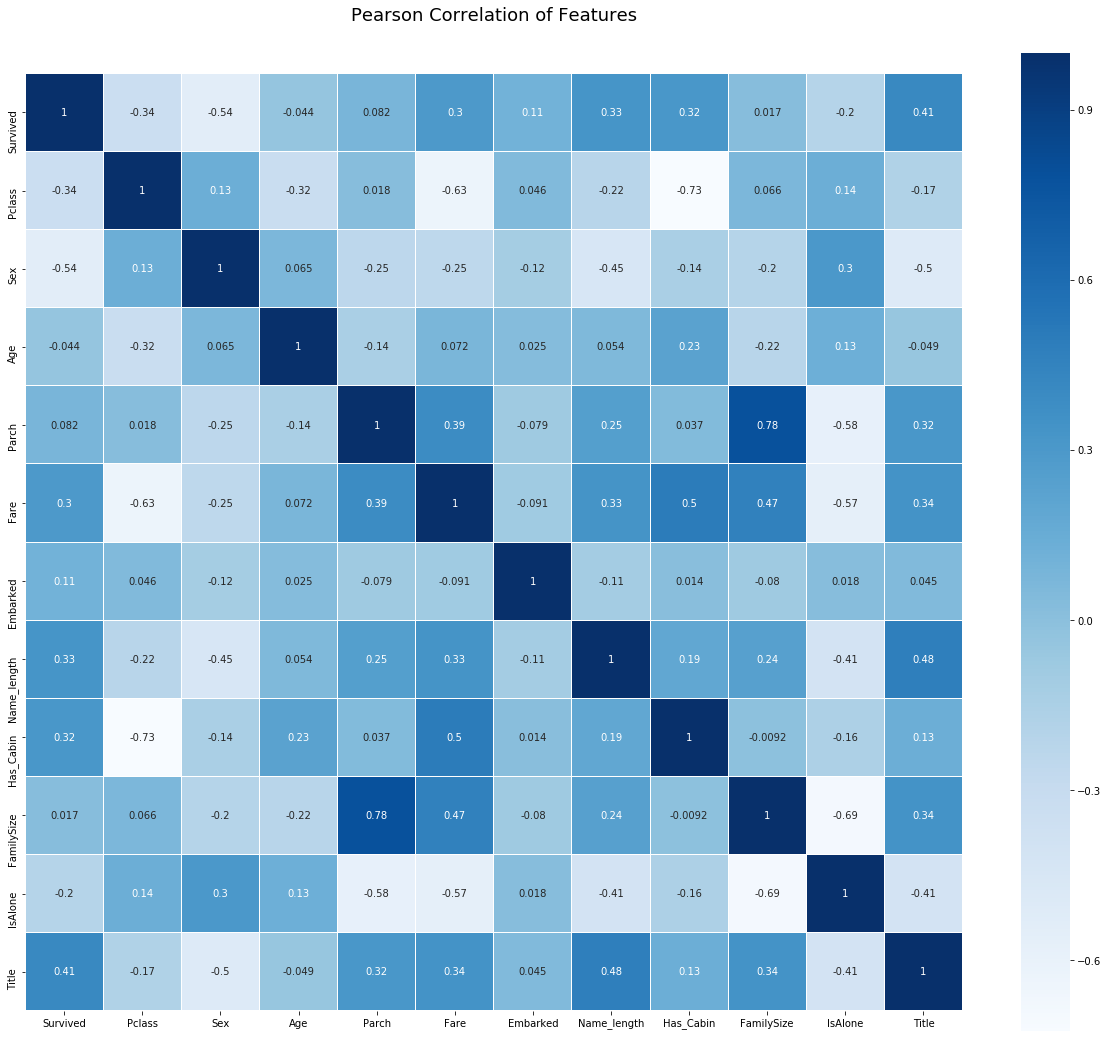

In [12]:
colormap = plt.cm.RdBu
plt.figure( figsize=(21,18))

# 그래프 이름
plt.title('Pearson Correlation of Features', y=1.05, size=18)

# 히트맵(사각형)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap="Blues", linecolor='white', annot=True)

### Takeaway from the plots - Pairplots

불필요한 데이터 x, 중복x -> 강한 연결을 갖는 두개의 feature들을 찾아본다.

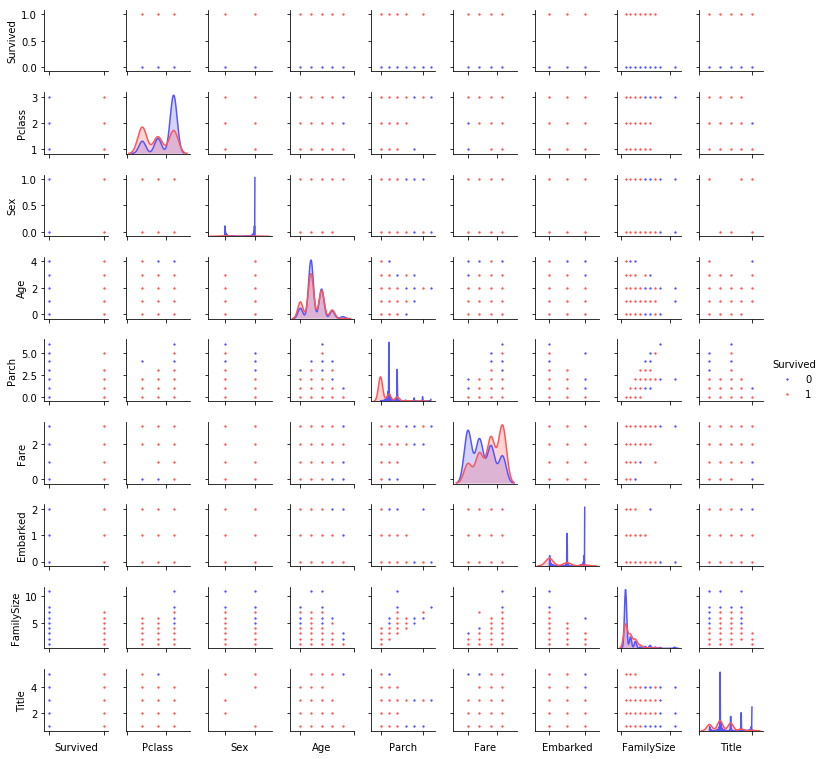

In [13]:
g= sns.pairplot( train[[u'Survived' ,u'Pclass', u'Sex',u'Age', u'Parch',
                       u'Fare',u'Embarked',u'FamilySize',u'Title' ]],
                hue='Survived', 
                palette='seismic', 
                size=1.2, 
                diag_kind='kde',
                diag_kws=dict(shade=True), 
                plot_kws=dict(s=10)
               )
g.set(xticklabels=[])

# Esembling & Stacking models

In [14]:
# Some useful parameters which will come in handy latter on 
ntrain = train.shape[0]
ntest= test.shape[0]
SEED=0 # for reproducibility
NFOLDS=5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

# class to extend the Sklearn classifier
class SklearnHelper(object):
    
    # SklearnHelper 클래스의 기본생성자
    def __init__ (self, clf, seed=0, params=None):
        params['random_state']= seed
        self.clf =clf(**params) # clf: 원하는 sklearn 분류기
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)
    

## Out-of-Fold Predictions

In [15]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr= x_train[train_index]
        y_tr= y_train[train_index]
        x_te= x_train[test_index]
        
        clf.train(x_tr, y_tr)
        oof_train[test_index]= clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:]=oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

# Generating Our Base First-Level models

first level classification을 준비..
1. Random Forest Classifier
2. Extra Trees Classifier
3. AdaBoost Classifier
4. Gradient Boosting Classifier
5. Support Vector Machine

In [16]:
# Random Forest Parameters
rf_params={
    'n_jobs': -1, 
    'n_estimators':500,
    'warm_start':True,
    'max_depth':6,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'verbose':0
}

# Extra Trees Parameters
et_params={
    'n_jobs':-1,
    'n_estimators':500,
    'max_depth':8,
    'min_samples_leaf':2,
    'verbose':0
}

# AdaBoost Parameters
ada_params={
    'n_estimators':500,
    'learning_rate':0.75
}

# Gradient Boosting Parameters
gb_params={
    'n_estimators':500,
    'max_depth':5,
    'min_samples_leaf':2,
    'verbose':0
}

# Support Vector Classifier parameters
svc_params={
    'kernel':'linear',
    'C':0.025
}

In [17]:
# SklearnHelper 클래스를 이용하여 5개의 분류모델 클래스 객체를 생성

rf=SklearnHelper( clf=RandomForestClassifier, seed=SEED, params=rf_params)

et=SklearnHelper( clf=ExtraTreesClassifier, seed=SEED, params=et_params)

ada=SklearnHelper( clf=AdaBoostClassifier, seed=SEED, params=ada_params)

gb=SklearnHelper( clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

svc=SklearnHelper( clf=SVC, seed=SEED, params=svc_params)

### Creating Numpy arrays out of our train and test sets

In [18]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

### Output of the First level predictions

첫번째 층 예측 결과

In [19]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) #Extra Trees

rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) #Random Forest

ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) #AdaBoost

gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) #GradientBoost

svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) #Support Vector Classifier

In [20]:
rf_feature = rf.feature_importances(x_train, y_train)

et_feature = et.feature_importances(x_train, y_train)

ada_feature= ada.feature_importances(x_train, y_train)

gb_feature= gb.feature_importances(x_train, y_train)

# support vector machine classifier(svc)에도 있나봤는데.. 
# 얘는 .. SVC object has no attribute feature_importances 라는 에러가뜬다. 
# svc_feature= svc.feature_importances(x_train, y_train)

[0.12308872 0.20153688 0.03372668 0.02071911 0.07075658 0.02356185
 0.10839754 0.06521153 0.06801178 0.01367802 0.2713113 ]
[0.11942756 0.38495367 0.02899338 0.01700813 0.05578208 0.02656186
 0.04651038 0.0839847  0.04422339 0.02203041 0.17052444]
[0.032 0.01  0.016 0.066 0.038 0.01  0.694 0.014 0.048 0.006 0.066]
[0.08490968 0.04554647 0.11202375 0.03267245 0.09092253 0.0593405
 0.37593382 0.0210383  0.07820199 0.01821998 0.08119054]


In [27]:
rf_result='0.12308872 0.20153688 0.03372668 0.02071911 0.07075658 0.02356185 0.10839754 0.06521153 0.06801178 0.01367802 0.2713113'

et_result='0.11942756 0.38495367 0.02899338 0.01700813 0.05578208 0.02656186  0.04651038 0.0839847  0.04422339 0.02203041 0.17052444'

ada_result='0.032 0.01  0.016 0.066 0.038 0.01  0.694 0.014 0.048 0.006 0.066'

gb_result='0.08490968 0.04554647 0.11202375 0.03267245 0.09092253 0.0593405 0.37593382 0.0210383  0.07820199 0.01821998 0.08119054'

rf_features=[ float(rf.strip()) for rf in rf_result.split(' ') if len(rf.strip())>0]

et_features=[ float(et.strip()) for et in et_result.split(' ') if len(et.strip())>0]

ada_features=[ float(ada.strip()) for ada in ada_result.split(' ') if len(ada.strip())>0]

gb_features=[ float(gb.strip()) for gb in gb_result.split(' ') if len(gb.strip())>0]


In [28]:
cols= train.columns.values

# create a dataframe with features
feature_dataframe= pd.DataFrame( {'features': cols,
                                 'Random Forest feature importances': rf_features,
                                 'Extra Trees feature importances': et_features,
                                 'AdaBoost feature importances': ada_features,
                                 'Gradient Boost feature importances': gb_features
                                 })

## Interactive feature importances via Plotly scatterplots

In [29]:
# Scatter plot - Random Forest
trace = go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text= feature_dataframe['features'].values
)

data=[trace]

layout= go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

측정할때마다 다르겠지만.. RandomForest 모델을 사용할 때

RandomForest가 가장중요하게 여기는 survived와 연관이 가장 깊은 feature는 Title 이다.

( Title> Sex > Pclass > Name_length)

In [30]:
# Scatter plot - Extra Trees
trace = go.Scatter(
    y=feature_dataframe['Extra Trees feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text= feature_dataframe['features'].values
)

data=[trace]

layout= go.Layout(
    autosize=True,
    title='ExtraTrees Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

ExtraTrees 분류기에서 생존가능성과 가장 연관된 feature은
Sex(성별), Title , Pclass 순이다..

In [31]:
# Scatter plot - AdaBoost
trace = go.Scatter(
    y=feature_dataframe['AdaBoost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text= feature_dataframe['features'].values
)

data=[trace]

layout= go.Layout(
    autosize=True,
    title='AdaBoost Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

AdaBoost 분류기로 했을 때 survived와 가장 밀접한 관계를 갖는 feature이... Name_length 이다..?
(이거 좀 이상한듯...;;;)

In [32]:
# Scatter plot - Gradient Boost
trace = go.Scatter(
    y=feature_dataframe['Gradient Boost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text= feature_dataframe['features'].values
)

data=[trace]

layout= go.Layout(
    autosize=True,
    title='GradientBoost Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

Gradient Boost 분류기로 돌렸을 때 survived와 가장 밀접하게 연관된게 Name_length...?
? 얘도 왜이러지..?

In [34]:
# 새로만들어서 각 분류기들의 결과 데이터를 합쳐서 평균을 내본다.
feature_dataframe['mean']= feature_dataframe.mean(axis=1)

feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.123089,0.119428,0.032,0.084910,0.089856
1,Sex,0.201537,0.384954,0.010,0.045546,0.160509
2,Age,0.033727,0.028993,0.016,0.112024,0.047686
3,Parch,0.020719,0.017008,0.066,0.032672,0.034100
4,Fare,0.070757,0.055782,0.038,0.090923,0.063865
5,Embarked,0.023562,0.026562,0.010,0.059340,0.029866
6,Name_length,0.108398,0.046510,0.694,0.375934,0.306210
7,Has_Cabin,0.065212,0.083985,0.014,0.021038,0.046059
8,FamilySize,0.068012,0.044223,0.048,0.078202,0.059609
9,IsAlone,0.013678,0.022030,0.006,0.018220,0.014982


? 왜...왜 .. Name_length지...???????

In [35]:
y= feature_dataframe['mean'].values
x= feature_dataframe['features'].values

data= [ go.Bar(x=x,
               y=y,
               width=0.5,
               marker=dict(
                   color=feature_dataframe['mean'].values,
                   colorscale='Portland',
                   showscale=True,
                   reversescale=False
               ),
               opacity=0.6
              )]

layout= go.Layout(
    autosize=True,
    title = 'Barplots of Mean Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

이건 아닌듯... 이건아니야.....
내컴퓨터가 안좋은거야....ㅠㅠㅠ

# Second-Level Prediction from the First-level Output

## First level output as new features

In [36]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost': ada_oof_train.ravel(),
                                       'GradientBoost':gb_oof_train.ravel()
                                       })

base_predictions_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0
8,1.0,0.0,1.0,1.0
9,1.0,1.0,1.0,1.0


## Correlation Heatmap of the Second Level Training set

In [37]:
data=[
    go.Heatmap(
        z=base_predictions_train.astype(float).corr().values,
        x=base_predictions_train.columns.values,
        y=base_predictions_train.columns.values,
        colorscale='Viridis',
        showscale=True,
        reversescale=True
    )
]

py.iplot(data, filename='labelled-heatmap')

In [38]:
# 두번째층 학습 모델에 맞게 첫번째층 예측결과를 모두 연결시켜서 ..x_train과 x_test 를 만들었다..
x_train = np.concatenate( ( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate( (et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

# Second level learning model via XGBoost

In [45]:
# max_depth: 당신의 트리를 얼마만큼 깊게 성장시킬건지.. 너무크면 오버피팅이 발생됨.
#  loss값 감소의 최소값, 이 값은 트리의 리프노드(자식x노드)에 대한 파티션..? 더 클수록 보수적인 알고리즘으로 될거다...
gbm= xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=4, 
    min_child_weight=2,
    gamma=0.9, 
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(x_train, y_train)

predictions=gbm.predict(x_test)

## producing the submission file

In [46]:
# Generate Submission File
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                                  'Survived': predictions})

StackingSubmission.to_csv('StackingSubmission.csv', index=False)